In [15]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [16]:
# 2. Đọc file csv và gắng index với giá Close
df=pd.read_csv('../../Dataset/GVR Historical Data.csv')
df['Date']=pd.to_datetime(df.Date, format ="%m/%d/%Y")
  # Sort the dataframe by date in ascending order
df = df.sort_values('Date')
# new_column_names = {'Ngày': 'Date', 'Lần cuối': 'Close', 'Mở': 'Open', 'Cao': 'High', 'Thấp': 'Low', '% Thay đổi': 'Volume'}
# df.rename(columns=new_column_names, inplace=True)

from datetime import datetime, date 


df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)

df.head().style.set_properties(subset=['Date'], **{'background-color': 'dodgerblue'})

df1=df.reset_index()['Price']

In [17]:
df1

0       10736.0
1       10342.0
2       10145.0
3       10736.0
4       11327.0
         ...   
1287    18200.0
1288    18400.0
1289    18200.0
1290    18800.0
1291    18900.0
Name: Price, Length: 1292, dtype: float64

In [18]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [19]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [20]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [21]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [23]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 4s 119ms/step - loss: 0.0207 - val_loss: 0.0329
Epoch 2/100
11/11 [==============================] - 1s 73ms/step - loss: 0.0072 - val_loss: 0.0267
Epoch 3/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0027 - val_loss: 0.0135
Epoch 4/100
11/11 [==============================] - 1s 89ms/step - loss: 8.5104e-04 - val_loss: 0.0032
Epoch 5/100
11/11 [==============================] - 1s 72ms/step - loss: 5.5375e-04 - val_loss: 0.0017
Epoch 6/100
11/11 [==============================] - 1s 61ms/step - loss: 5.3116e-04 - val_loss: 0.0020
Epoch 7/100
11/11 [==============================] - 1s 80ms/step - loss: 4.5363e-04 - val_loss: 0.0014
Epoch 8/100
11/11 [==============================] - 1s 70ms/step - loss: 4.5439e-04 - val_loss: 0.0013
Epoch 9/100
11/11 [==============================] - 1s 75ms/step - loss: 4.3516e-04 - val_loss: 0.0013
Epoch 10/100
11/11 [==============================] - 1s 80ms/step - loss:

In [25]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 17ms/step


In [26]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [27]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 14982.89285550754
Testing RMSE: 33922.52245266179


In [28]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=198
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.50742516 0.50032156 0.49462114 0.49035313 0.47468428 0.48324953
 0.48892072 0.52595884 0.52452643 0.5117224  0.5601029  0.55156688
 0.54729888 0.53876286 0.53589804 0.51312558 0.52309401 0.51312558
 0.514558   0.51312558 0.52736202 0.50175398 0.45334425 0.47041628
 0.46331268 0.4732811  0.46614827 0.45617984 0.44907624 0.43340739
 0.3963985  0.3963985  0.35512161 0.32094832 0.34515318 0.30814429
 0.273971   0.28250702 0.24976614 0.26759822 0.26905987 0.28221469
 0.28659963 0.29244621 0.28513798 0.27490645 0.24275023 0.21205566
 0.19013096 0.19597755 0.22228718 0.22521048 0.22228718 0.22521048
 0.2164406  0.21790225 0.19159261 0.16528297 0.18282273 0.19013096
 0.16382133 0.13897334 0.115587   0.0936623  0.11412535 0.1345884
 0.1565131  0.18136109 0.16966791 0.16820627 0.18136109 0.19597755
 0.21351731 0.21497895 0.2164406  0.23398036 0.25444341 0.2573667
 0.22667212 0.21059401 0.23105706 0.24128859 0.23398036 0.23982694
 0.25444341 0.2573667  0.26321328 0.24859682 0.21936

0 day output [[0.35466906]]
1 day input [0.50032156 0.49462114 0.49035313 0.47468428 0.48324953 0.48892072
 0.52595884 0.52452643 0.5117224  0.5601029  0.55156688 0.54729888
 0.53876286 0.53589804 0.51312558 0.52309401 0.51312558 0.514558
 0.51312558 0.52736202 0.50175398 0.45334425 0.47041628 0.46331268
 0.4732811  0.46614827 0.45617984 0.44907624 0.43340739 0.3963985
 0.3963985  0.35512161 0.32094832 0.34515318 0.30814429 0.273971
 0.28250702 0.24976614 0.26759822 0.26905987 0.28221469 0.28659963
 0.29244621 0.28513798 0.27490645 0.24275023 0.21205566 0.19013096
 0.19597755 0.22228718 0.22521048 0.22228718 0.22521048 0.2164406
 0.21790225 0.19159261 0.16528297 0.18282273 0.19013096 0.16382133
 0.13897334 0.115587   0.0936623  0.11412535 0.1345884  0.1565131
 0.18136109 0.16966791 0.16820627 0.18136109 0.19597755 0.21351731
 0.21497895 0.2164406  0.23398036 0.25444341 0.2573667  0.22667212
 0.21059401 0.23105706 0.24128859 0.23398036 0.23982694 0.25444341
 0.2573667  0.26321328 0.2485

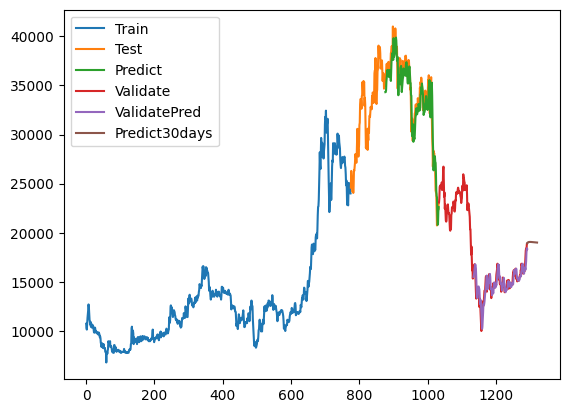

In [29]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [30]:
yval=scaler.inverse_transform(yval.reshape(-1, 1))
ytest=scaler.inverse_transform(ytest.reshape(-1, 1))

In [31]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
from sklearn.metrics import mean_absolute_percentage_error


vail_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', vail_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 517.78060912777
Testing RMSE: 1092.6023561427512
Validation MAPE: 0.027393655415647332
Testing MAPE: 0.02683956395339224
